In [1]:
import pandas as pd
import numpy as np
import timeit
from sklearnex import patch_sklearn
patch_sklearn(global_patch = True)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import scipy.stats as stats
import seaborn as sns
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from skopt import BayesSearchCV
import shap

# Loading the dataset
df = pd.read_csv(r'data_with_new_features.csv', delimiter = ',')

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df

,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),...,Tuition fees up to date,Gender,Scholarship holder,International,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Target,age_bins,Admission grade (bins),Previous grade (bins)
0,127.3,3.044522,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0.000000,0.000000,Dropout,1,3,1
1,142.5,2.995732,0.0,1.945910,6.0,6.0,0.0,0.0,6.0,6.0,...,0,1,0,0,2.708050,2.685577,Graduate,0,4,6
2,124.8,2.995732,0.0,1.945910,0.0,0.0,0.0,0.0,6.0,0.0,...,0,1,0,0,0.000000,0.000000,Dropout,0,2,1
3,119.6,3.044522,0.0,1.945910,8.0,6.0,0.0,0.0,6.0,10.0,...,1,0,0,0,2.669210,2.595255,Graduate,1,2,1
4,141.5,3.828641,0.0,1.945910,9.0,5.0,0.0,0.0,6.0,6.0,...,1,0,0,0,2.590267,2.639057,Graduate,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,122.2,2.995732,0.0,1.945910,7.0,5.0,0.0,0.0,6.0,8.0,...,1,1,0,0,2.681022,2.614960,Graduate,0,2,2
4420,119.0,2.944439,0.0,1.945910,6.0,6.0,0.0,0.0,6.0,6.0,...,0,0,0,1,2.564949,2.484907,Dropout,0,2,1
4421,149.5,3.433987,0.0,2.079442,8.0,7.0,0.0,0.0,8.0,9.0,...,1,0,1,0,2.767105,2.674149,Dropout,3,5,5
4422,153.8,3.044522,0.0,1.791759,5.0,5.0,0.0,0.0,5.0,6.0,...,1,0,1,0,2.694627,2.564949,Graduate,1,5,7


In [3]:
# Splitting the dataset to hold the independent and target variables where X represents the independent variable and y the target variable.
X = df.drop('Target', axis=1)
y = df['Target']
y = y.replace({'Dropout': 1, 'Enrolled': 0, 'Graduate': 0})

In [4]:
# Splitting the dataset into train, validation and test dataset 60%-20%-20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=105)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=105)

In [5]:
x_eval = pd.concat([x_train, x_val])
y_eval = pd.concat([y_train, y_val])

In [7]:
x_train.to_csv('train_dataset.csv')

In [8]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
def plot_loss_accuracy(history, figsize=(15, 10)):
    sns.set()  # Use seaborn styling for better aesthetics
    
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot Training and Validation Accuracy on the first subplot
    ax1.plot(history.epoch, history.history["accuracy"], label='Training Accuracy', color='blue')
    ax1.plot(history.epoch, history.history["val_accuracy"], label='Validation Accuracy', color='orange')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Training and Validation Accuracy')

    # Plot Training and Validation Loss on the second subplot
    ax2.plot(history.epoch, history.history["loss"], label='Training Loss', color='green', linestyle='--')
    ax2.plot(history.epoch, history.history["val_loss"], label='Validation Loss', color='red', linestyle='--')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Training and Validation Loss')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


In [10]:
def ANN_model_evaluation(clf, X_te, y_te, phase):
    print('\n Model Evaluation Result For the {} Phase \n'.format(phase))
    #Calculate start time for prediction
    start = timeit.default_timer()
        # Predict the model
    pred =clf.predict(X_te)
    pred_class = np.array([1 if i >= 0.5  else 0 for i in pred])

    #Calculate Stop time
    stop = timeit.default_timer()
    test_time= stop - start
    
#     print('Train Time(s):', train_time)

    #Test time
    print('Test Time(s):',test_time)
    
#     train_pred = clf.predict(X_tr)
    
#     train_acc = accuracy_score(y_tr, train_pred)
    
#     print('Training Accuracy:  {}%\n'.format(round(train_acc, 2)*100))
    
    accuracy = accuracy_score(y_te, pred_class)
    
    report = classification_report(y_te, pred_class)
    
    print('Accuracy:  {}%\n'.format(round(accuracy, 2)*100))
    
    print(report, '\n')
    
    cf_matrix = confusion_matrix(y_te, pred_class)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    y_pred_proba = pred.ravel()  # .ravel() to flatten the output

    # Calculate False Positive Rate, True Positive Rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



In [11]:
def save_keras_model(model, filename):
    try:
        # Save the entire model (architecture + weights + optimizer state)
        model.save(filename)
        print(f"Keras model saved successfully to {filename}")
    except Exception as e:
        print(f"Error saving Keras model: {e}")


In [12]:
mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
x_val = mm.transform(x_val)
x_test = mm.transform(x_test)

In [13]:
import os
os.environ['PYTHONHASHSEED']=str(105)
tf.random.set_seed(105)

In [14]:
model = Sequential()
model.add(Dense(256, input_shape = (x_train.shape[1], ), activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [15]:
es = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 10,
                   verbose = 1, restore_best_weights = True, start_from_epoch = 20)

In [16]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
history_1 = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 5s 31ms/step - loss: 0.4627 - accuracy: 0.7803 - val_loss: 0.3864 - val_accuracy: 0.8407
Epoch 2/200
42/42 [==============================] - 0s 10ms/step - loss: 0.3341 - accuracy: 0.8704 - val_loss: 0.4305 - val_accuracy: 0.8215
Epoch 3/200
42/42 [==============================] - 0s 8ms/step - loss: 0.3238 - accuracy: 0.8772 - val_loss: 0.3612 - val_accuracy: 0.8599
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3253 - accuracy: 0.8730 - val_loss: 0.3641 - val_accuracy: 0.8542
Epoch 5/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3218 - accuracy: 0.8753 - val_loss: 0.3515 - val_accuracy: 0.8531
Epoch 6/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3214 - accuracy: 0.8757 - val_loss: 0.3491 - val_accuracy: 0.8633
Epoch 7/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3197 - accuracy: 0.8730 - val_loss: 0.3677 - val_accuracy: 0.8554
Epoch 8/200

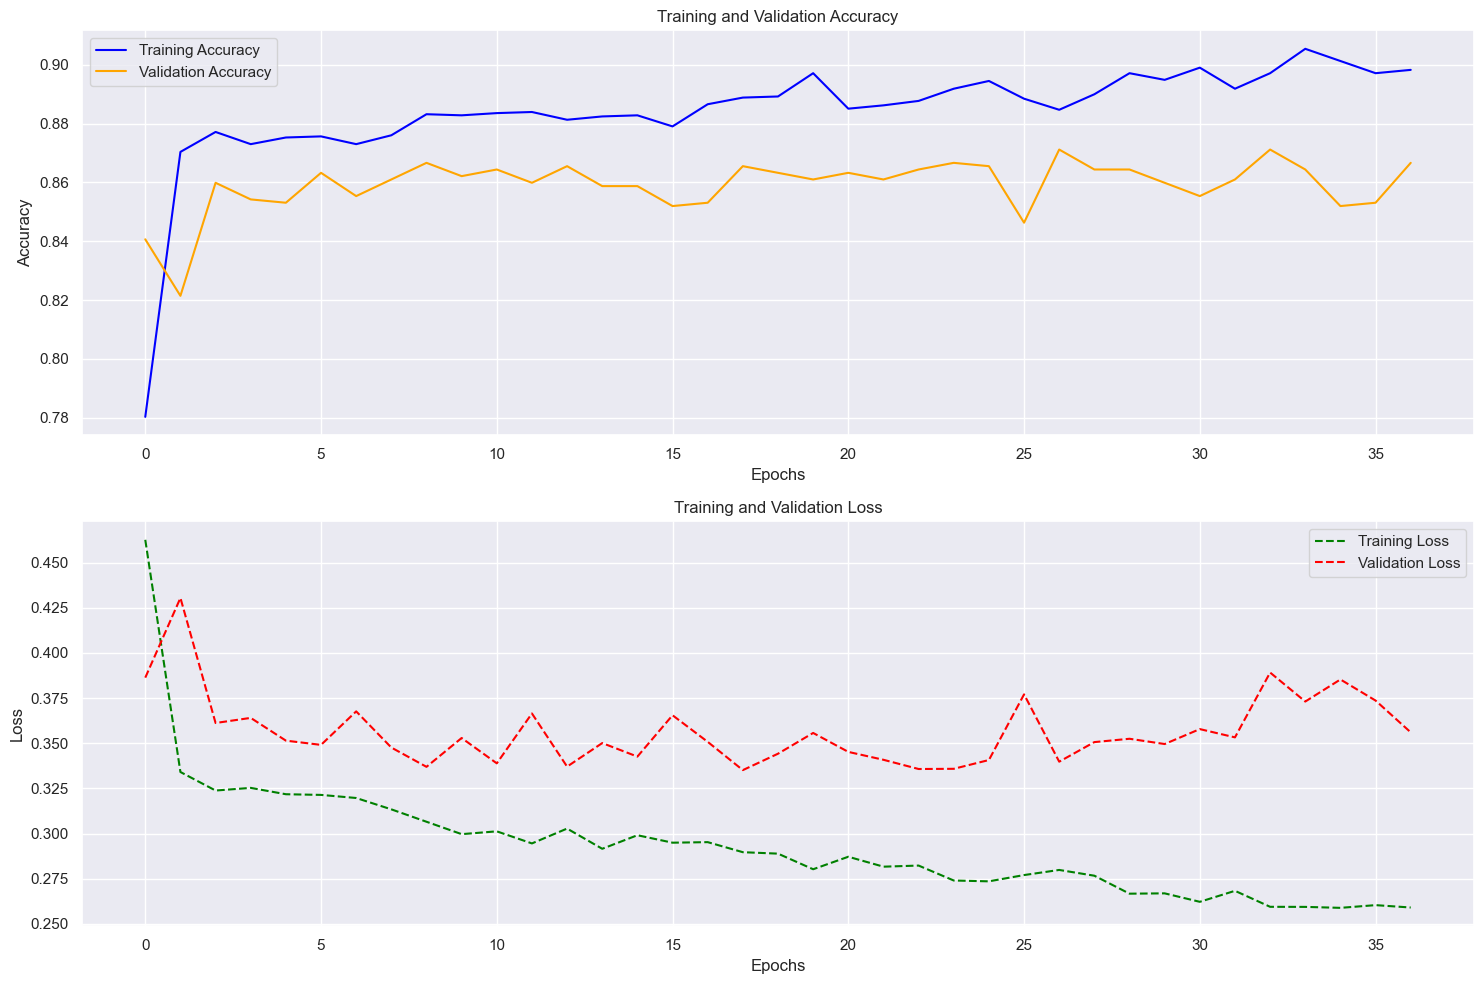

In [18]:
plot_loss_accuracy(history_1)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 1s 5ms/step
Test Time(s): 0.8433196000114549
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       594
           1       0.86      0.73      0.79       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.85       885
weighted avg       0.87      0.87      0.87       885
 



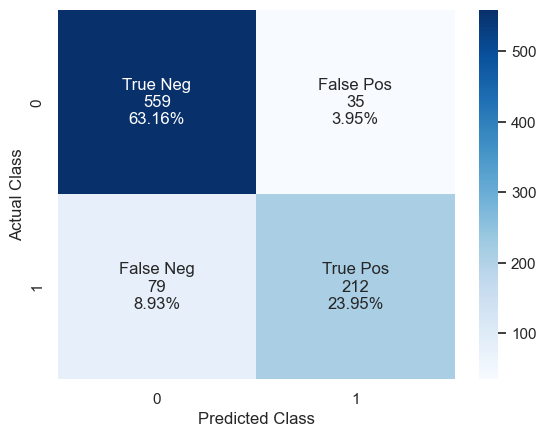

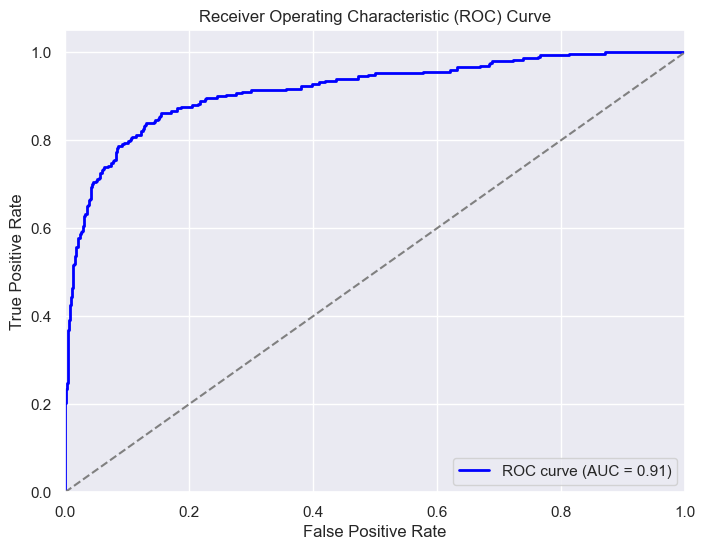

In [19]:
ANN_model_evaluation(model, x_test, y_test, phase = 'Test')

In [21]:
save_keras_model(model, 'model.keras')

Keras model saved successfully to model.keras


In [22]:
plot_model(model, to_file="model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
model1 = Sequential()
model1.add(Dense(2048, input_shape = (x_train.shape[1], ), activation = 'relu'))
model1.add(Dense(1024, activation = 'relu'))
model1.add(Dense(512, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [24]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
history_2 = model1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 10s 174ms/step - loss: 0.4779 - accuracy: 0.7509 - val_loss: 0.3746 - val_accuracy: 0.8407
Epoch 2/200
42/42 [==============================] - 5s 115ms/step - loss: 0.3661 - accuracy: 0.8561 - val_loss: 0.3614 - val_accuracy: 0.8565
Epoch 3/200
42/42 [==============================] - 5s 122ms/step - loss: 0.3400 - accuracy: 0.8719 - val_loss: 0.3768 - val_accuracy: 0.8520
Epoch 4/200
42/42 [==============================] - 5s 121ms/step - loss: 0.3338 - accuracy: 0.8693 - val_loss: 0.3783 - val_accuracy: 0.8531
Epoch 5/200
42/42 [==============================] - 5s 115ms/step - loss: 0.3204 - accuracy: 0.8775 - val_loss: 0.3458 - val_accuracy: 0.8576
Epoch 6/200
42/42 [==============================] - 5s 114ms/step - loss: 0.3296 - accuracy: 0.8693 - val_loss: 0.3567 - val_accuracy: 0.8644
Epoch 7/200
42/42 [==============================] - 5s 116ms/step - loss: 0.3114 - accuracy: 0.8828 - val_loss: 0.3924 - val_accuracy: 0.866

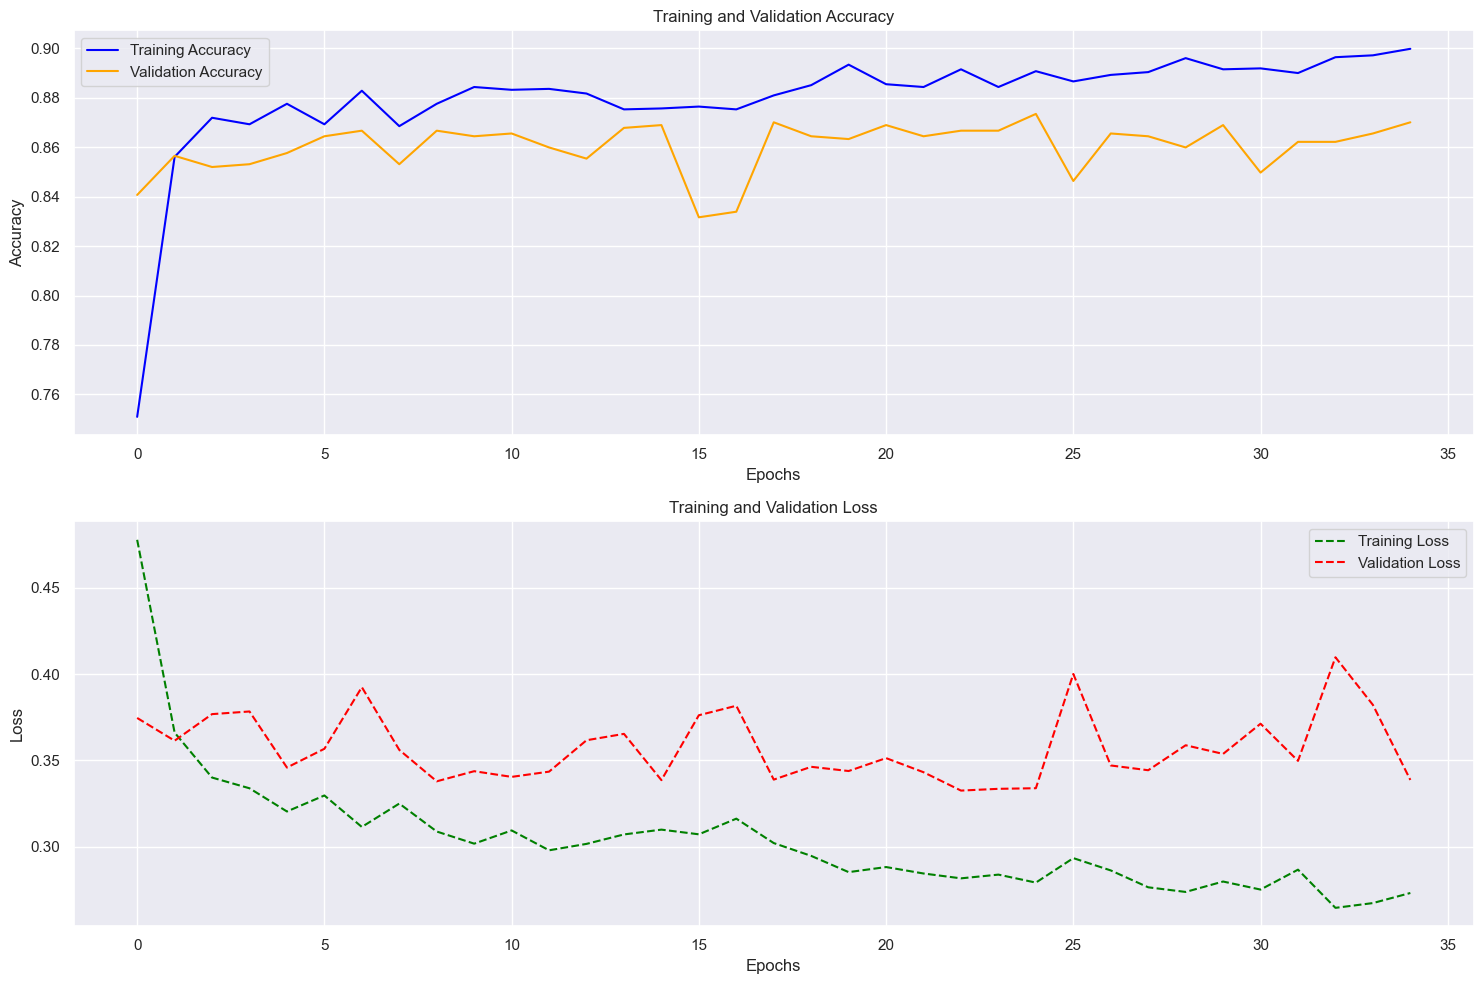

In [26]:
plot_loss_accuracy(history_2)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 1s 21ms/step
Test Time(s): 1.0418514999910258
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       594
           1       0.86      0.69      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885
 



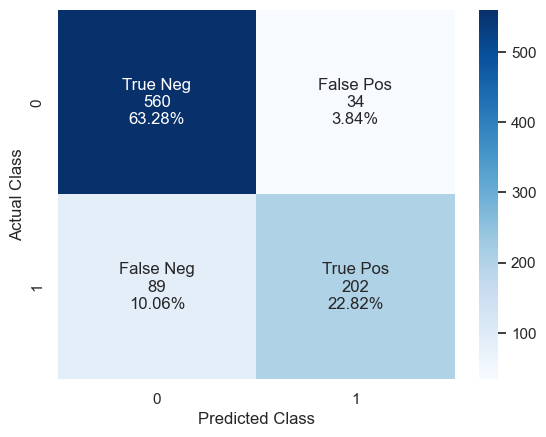

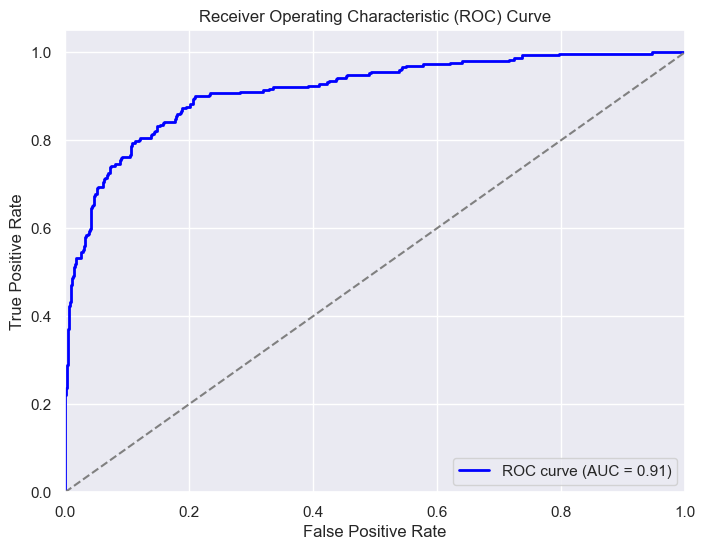

In [27]:
ANN_model_evaluation(model1, x_test, y_test, phase = 'Test')

In [28]:
save_keras_model(model, 'model1.keras')

Keras model saved successfully to model1.keras


In [29]:
plot_model(model, to_file="model1.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
model_reg = Sequential()
model_reg.add(Dense(128, input_shape = (x_train.shape[1], ), activation = 'relu'))
model_reg.add(Dense(64, activation = 'relu'))
model_reg.add(Dense(8, activation = 'relu'))
model_reg.add(Dense(1, activation = 'sigmoid'))

In [31]:
model_reg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
history_3 = model_reg.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 3s 12ms/step - loss: 0.4286 - accuracy: 0.8063 - val_loss: 0.3850 - val_accuracy: 0.8373
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3431 - accuracy: 0.8640 - val_loss: 0.3642 - val_accuracy: 0.8554
Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3257 - accuracy: 0.8772 - val_loss: 0.3616 - val_accuracy: 0.8621
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3290 - accuracy: 0.8693 - val_loss: 0.3704 - val_accuracy: 0.8565
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3212 - accuracy: 0.8749 - val_loss: 0.3496 - val_accuracy: 0.8633
Epoch 6/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3153 - accuracy: 0.8772 - val_loss: 0.3508 - val_accuracy: 0.8621
Epoch 7/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3153 - accuracy: 0.8775 - val_loss: 0.3575 - val_accuracy: 0.8599
Epoch 8/200


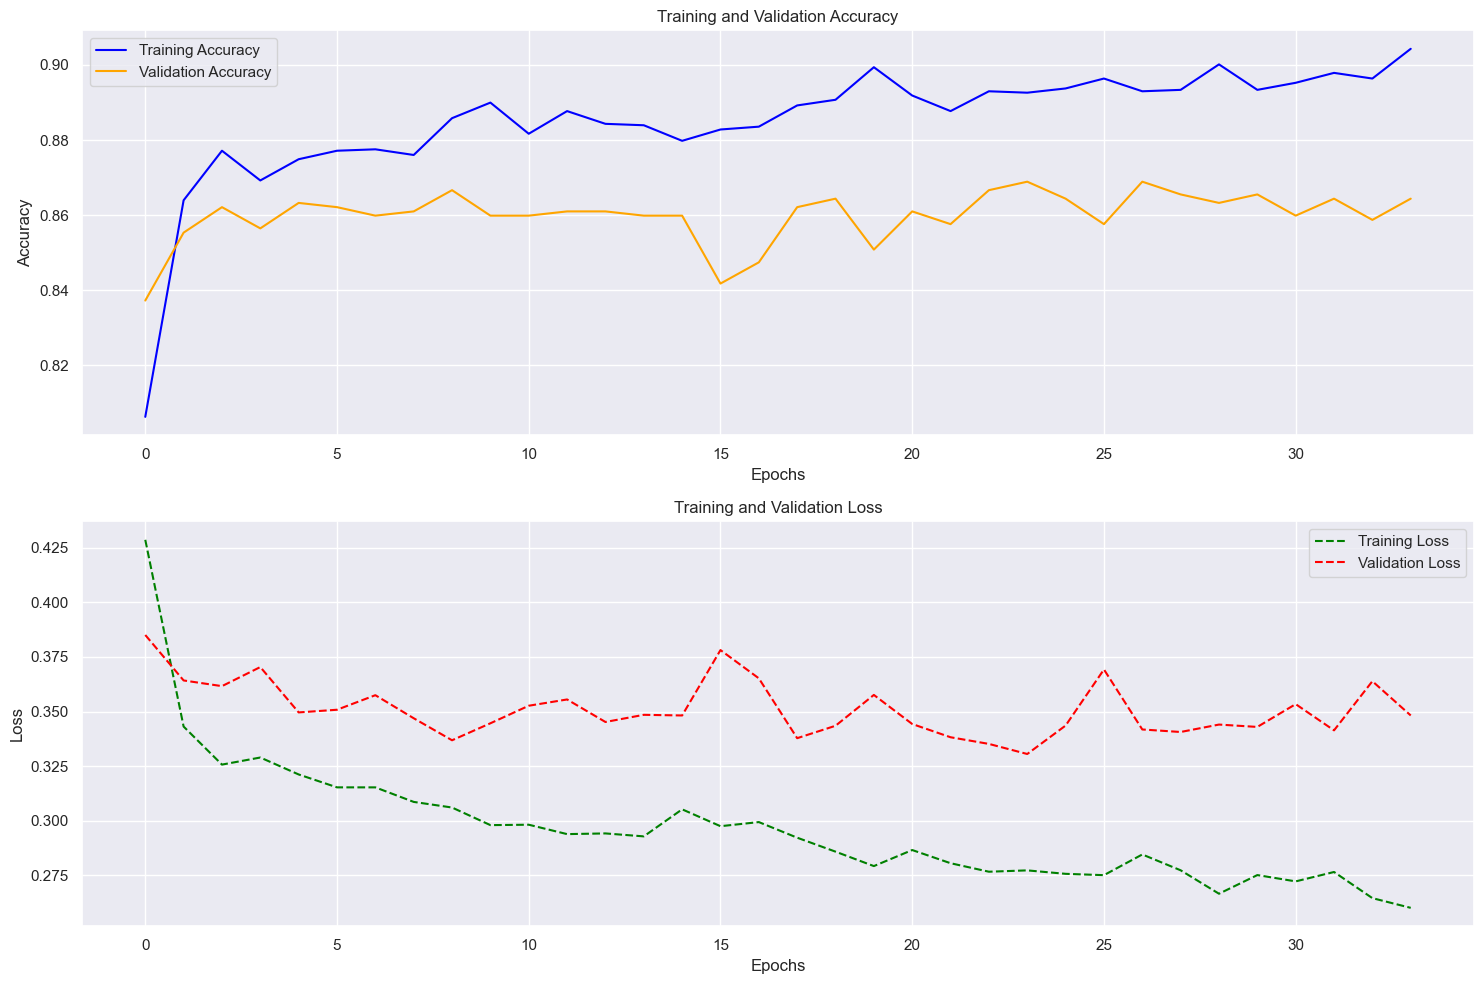

In [33]:
plot_loss_accuracy(history_3)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 3ms/step
Test Time(s): 0.49417299998458475
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.88      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



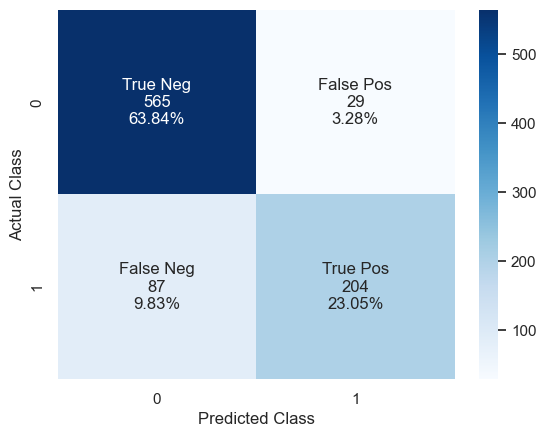

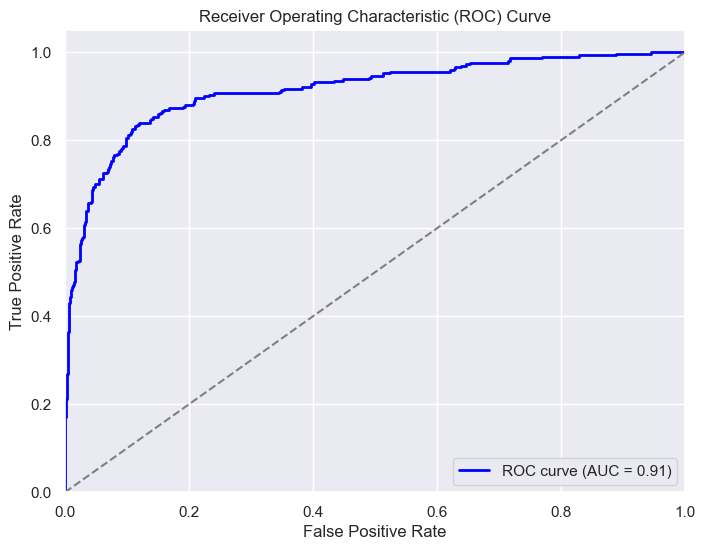

In [34]:
ANN_model_evaluation(model_reg, x_test, y_test, phase = 'Test')

In [35]:
save_keras_model(model, 'model2.keras')

Keras model saved successfully to model2.keras


In [36]:
plot_model(model, to_file="model2.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
model_reg1 = Sequential()
model_reg1.add(Dense(256, input_shape = (x_train.shape[1], ), activation = 'relu'))
model_reg1.add(Dense(128, activation = 'relu'))
model_reg1.add(Dense(8, activation = 'relu'))
model_reg1.add(Dense(8, activation = 'relu'))
model_reg1.add(Dense(1, activation = 'sigmoid'))

In [38]:
model_reg1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_4 = model_reg1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 2s 13ms/step - loss: 0.4543 - accuracy: 0.7830 - val_loss: 0.4100 - val_accuracy: 0.8282
Epoch 2/200
42/42 [==============================] - 0s 10ms/step - loss: 0.3482 - accuracy: 0.8580 - val_loss: 0.3604 - val_accuracy: 0.8621
Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3318 - accuracy: 0.8685 - val_loss: 0.3546 - val_accuracy: 0.8610
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3256 - accuracy: 0.8708 - val_loss: 0.3649 - val_accuracy: 0.8542
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3194 - accuracy: 0.8749 - val_loss: 0.3452 - val_accuracy: 0.8554
Epoch 6/200
42/42 [==============================] - 0s 7ms/step - loss: 0.3155 - accuracy: 0.8749 - val_loss: 0.3469 - val_accuracy: 0.8644
Epoch 7/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3129 - accuracy: 0.8802 - val_loss: 0.3643 - val_accuracy: 0.8565
Epoch 8/200

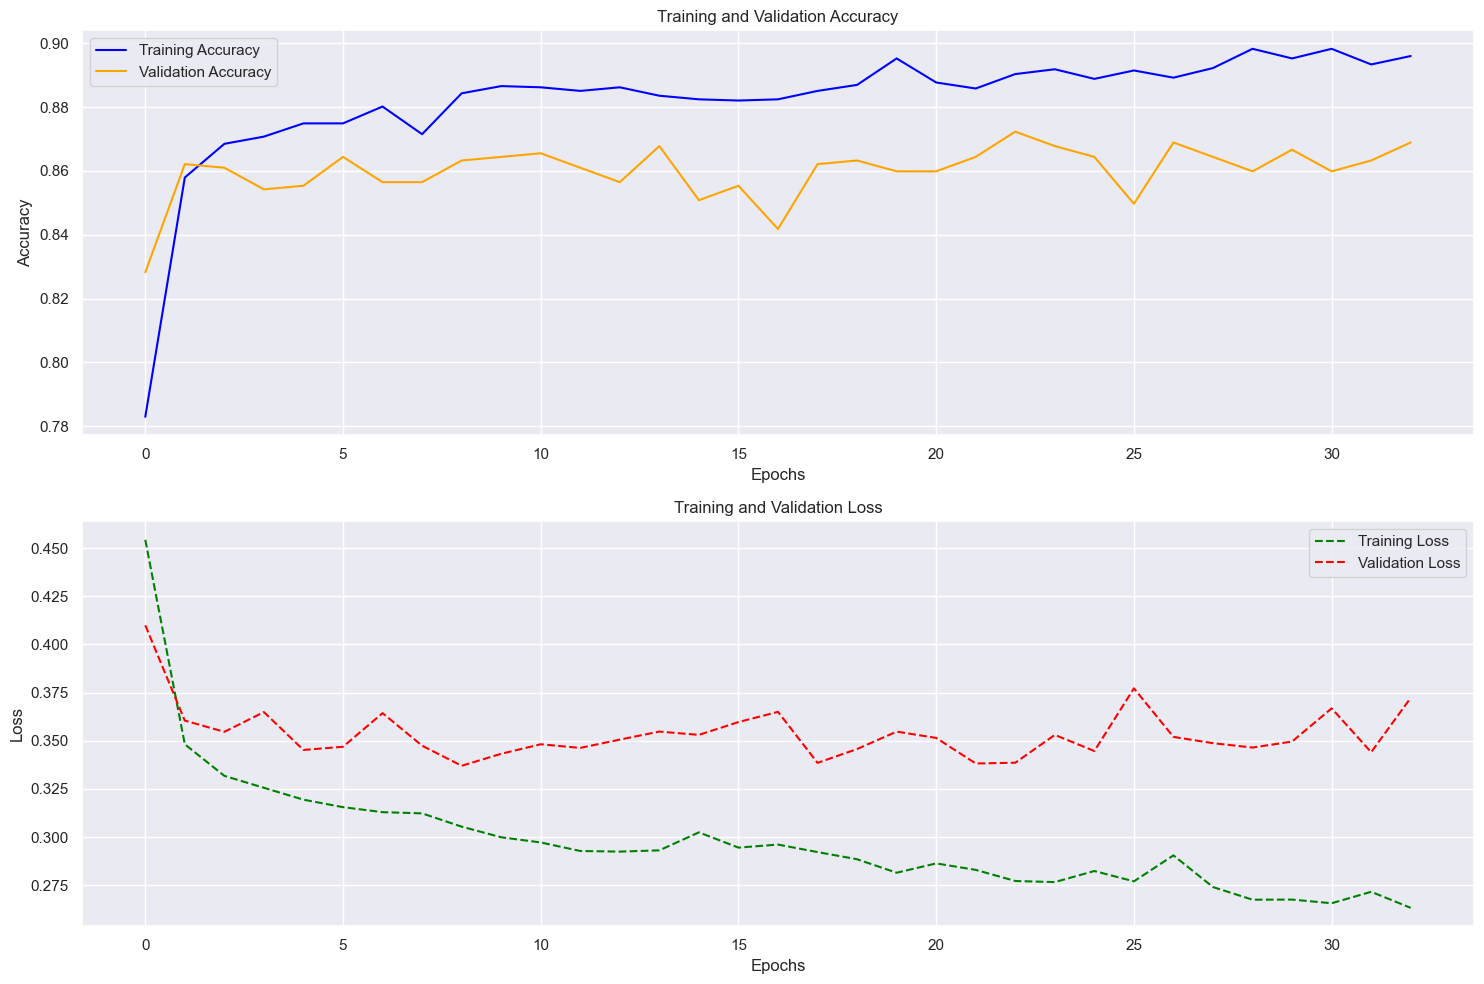

In [39]:
plot_loss_accuracy(history_4)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 4ms/step
Test Time(s): 0.5777692999981809
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       594
           1       0.84      0.75      0.79       291

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885
 



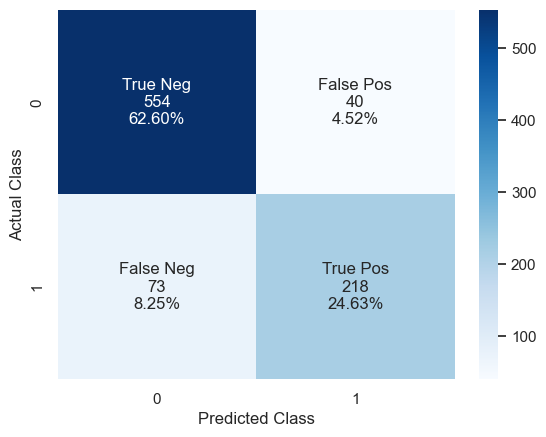

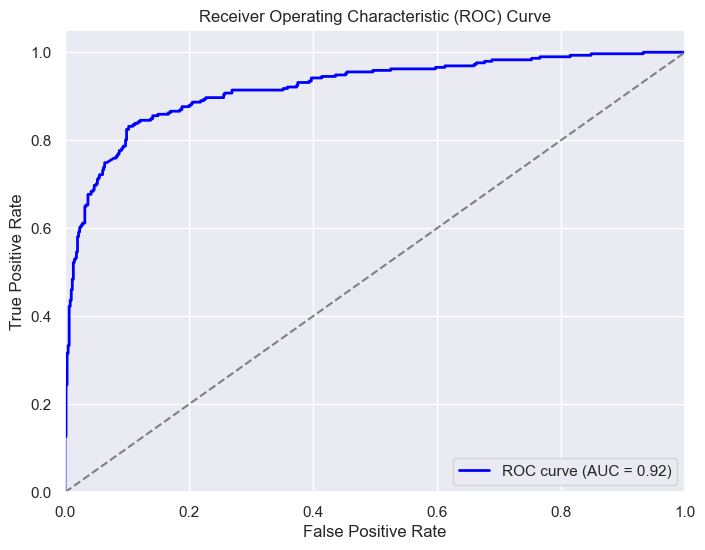

In [40]:
ANN_model_evaluation(model_reg1, x_test, y_test, phase = 'Test')

In [61]:
save_keras_model(model, 'model3.keras')

Keras model saved successfully to model3.keras


In [42]:
plot_model(model, to_file="model3.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
model3 = Sequential()
model3.add(Dense(2048, input_shape = (x_train.shape[1], ), activation = 'relu'))
model3.add(Dense(1024, activation = 'relu'))
model3.add(Dense(512, activation = 'relu'))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(8, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

In [44]:
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_5 = model3.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 10s 158ms/step - loss: 0.4637 - accuracy: 0.7803 - val_loss: 0.3643 - val_accuracy: 0.8418
Epoch 2/200
42/42 [==============================] - 6s 146ms/step - loss: 0.3566 - accuracy: 0.8568 - val_loss: 0.3580 - val_accuracy: 0.8508
Epoch 3/200
42/42 [==============================] - 4s 102ms/step - loss: 0.3420 - accuracy: 0.8696 - val_loss: 0.3641 - val_accuracy: 0.8610
Epoch 4/200
42/42 [==============================] - 3s 71ms/step - loss: 0.3300 - accuracy: 0.8711 - val_loss: 0.3719 - val_accuracy: 0.8621
Epoch 5/200
42/42 [==============================] - 3s 73ms/step - loss: 0.3210 - accuracy: 0.8708 - val_loss: 0.3442 - val_accuracy: 0.8621
Epoch 6/200
42/42 [==============================] - 7s 155ms/step - loss: 0.3293 - accuracy: 0.8685 - val_loss: 0.3647 - val_accuracy: 0.8633
Epoch 7/200
42/42 [==============================] - 4s 87ms/step - loss: 0.3104 - accuracy: 0.8828 - val_loss: 0.3764 - val_accuracy: 0.8689
E

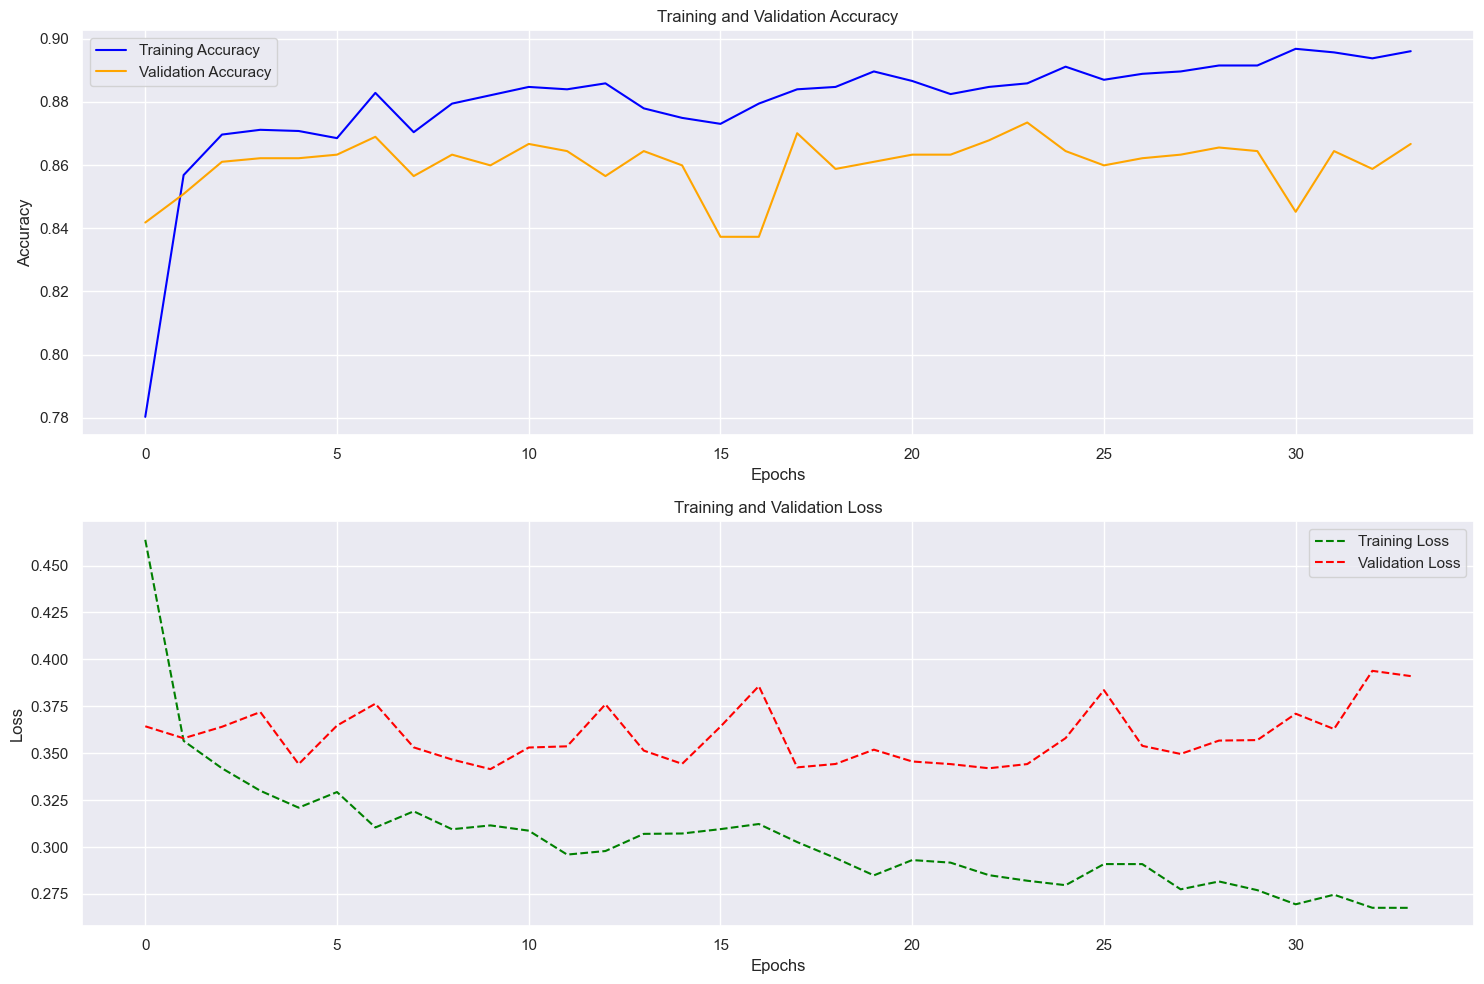

In [45]:
plot_loss_accuracy(history_5)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 1s 12ms/step
Test Time(s): 0.6167028999770992
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       594
           1       0.87      0.69      0.77       291

    accuracy                           0.87       885
   macro avg       0.87      0.82      0.84       885
weighted avg       0.87      0.87      0.86       885
 



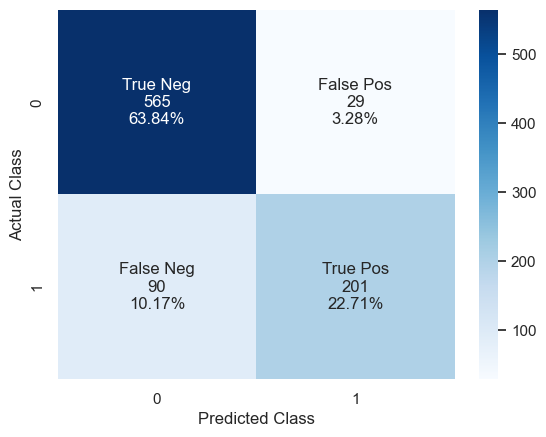

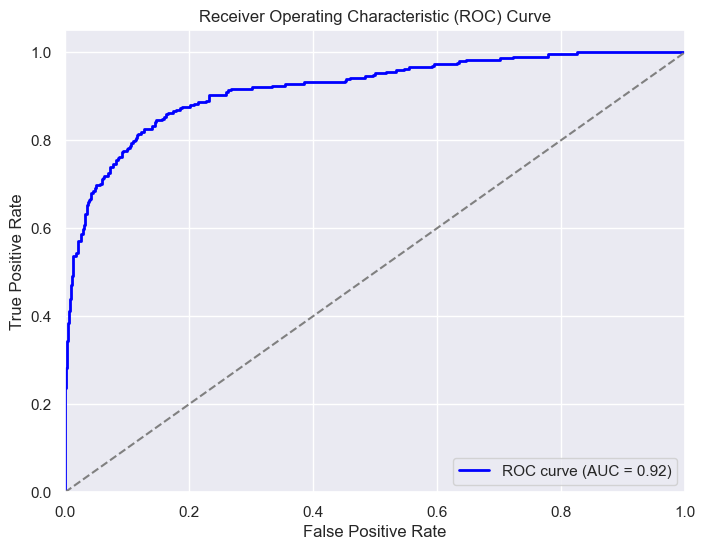

In [46]:
ANN_model_evaluation(model3, x_test, y_test, phase = 'Test')

In [62]:
save_keras_model(model, 'model4.keras')

Keras model saved successfully to model4.keras


In [48]:
plot_model(model, to_file="model4.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:
model4 = Sequential()
model4.add(Dense(4096, input_shape = (x_train.shape[1], ), activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(2048, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1024, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(512, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(8, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))

In [50]:
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_6 = model4.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 15s 286ms/step - loss: 0.5182 - accuracy: 0.7524 - val_loss: 0.3925 - val_accuracy: 0.8350
Epoch 2/200
42/42 [==============================] - 10s 236ms/step - loss: 0.3821 - accuracy: 0.8451 - val_loss: 0.4053 - val_accuracy: 0.8350
Epoch 3/200
42/42 [==============================] - 9s 216ms/step - loss: 0.3710 - accuracy: 0.8564 - val_loss: 0.3606 - val_accuracy: 0.8576
Epoch 4/200
42/42 [==============================] - 9s 226ms/step - loss: 0.3521 - accuracy: 0.8613 - val_loss: 0.4203 - val_accuracy: 0.8215
Epoch 5/200
42/42 [==============================] - 10s 233ms/step - loss: 0.3486 - accuracy: 0.8591 - val_loss: 0.3780 - val_accuracy: 0.8565
Epoch 6/200
42/42 [==============================] - 10s 227ms/step - loss: 0.3668 - accuracy: 0.8666 - val_loss: 0.3628 - val_accuracy: 0.8633
Epoch 7/200
42/42 [==============================] - 9s 219ms/step - loss: 0.3396 - accuracy: 0.8708 - val_loss: 0.3665 - val_accuracy: 0.

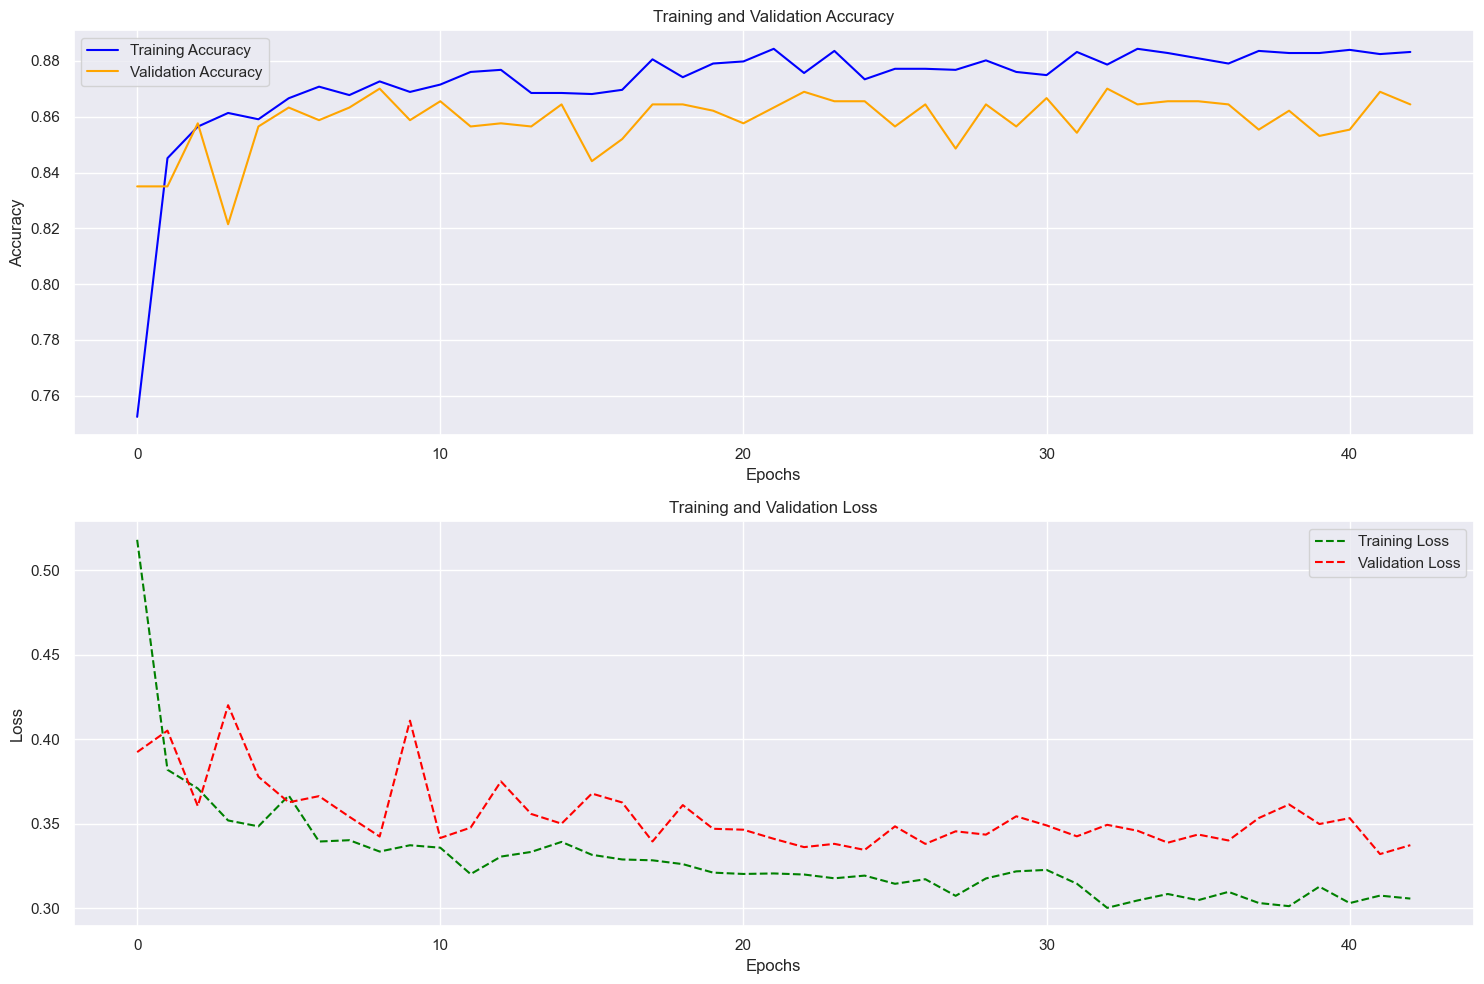

In [51]:
plot_loss_accuracy(history_6)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 1s 23ms/step
Test Time(s): 1.9754304000234697
Accuracy:  86.0%

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       594
           1       0.86      0.70      0.77       291

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.86      0.86      0.86       885
 



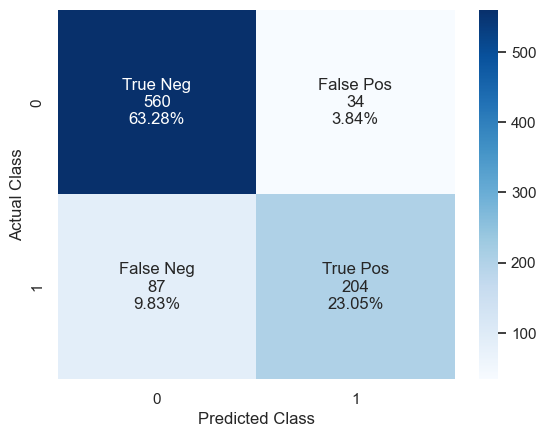

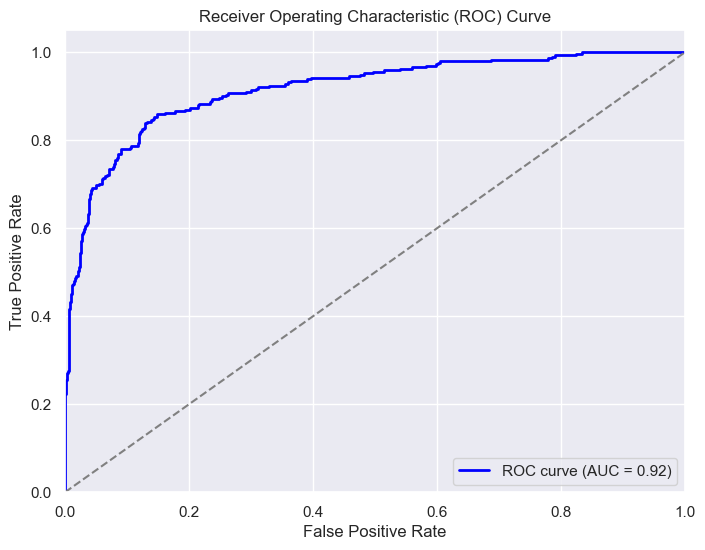

In [52]:
ANN_model_evaluation(model4, x_test, y_test, phase = 'Test')

In [63]:
save_keras_model(model, 'model5.keras')

Keras model saved successfully to model5.keras


In [54]:
plot_model(model, to_file="model5.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [55]:
model5 = Sequential()
model5.add(Dense(4, input_shape = (x_train.shape[1], ), activation = 'relu'))
model5.add(Dense(16, activation = 'relu'))
model5.add(Dense(16, activation = 'relu'))
model5.add(Dense(64, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(1, activation = 'sigmoid'))

In [56]:
model5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_7 = model5.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 64, callbacks = [es])

Epoch 1/200
42/42 [==============================] - 5s 35ms/step - loss: 0.5486 - accuracy: 0.7087 - val_loss: 0.4597 - val_accuracy: 0.8158
Epoch 2/200
42/42 [==============================] - 1s 14ms/step - loss: 0.4055 - accuracy: 0.8402 - val_loss: 0.4023 - val_accuracy: 0.8362
Epoch 3/200
42/42 [==============================] - 1s 16ms/step - loss: 0.3590 - accuracy: 0.8531 - val_loss: 0.3761 - val_accuracy: 0.8452
Epoch 4/200
42/42 [==============================] - 1s 17ms/step - loss: 0.3434 - accuracy: 0.8613 - val_loss: 0.3739 - val_accuracy: 0.8384
Epoch 5/200
42/42 [==============================] - 1s 21ms/step - loss: 0.3352 - accuracy: 0.8625 - val_loss: 0.3661 - val_accuracy: 0.8542
Epoch 6/200
42/42 [==============================] - 1s 14ms/step - loss: 0.3241 - accuracy: 0.8749 - val_loss: 0.3708 - val_accuracy: 0.8531
Epoch 7/200
42/42 [==============================] - 1s 16ms/step - loss: 0.3244 - accuracy: 0.8738 - val_loss: 0.3736 - val_accuracy: 0.8610
Epoch 

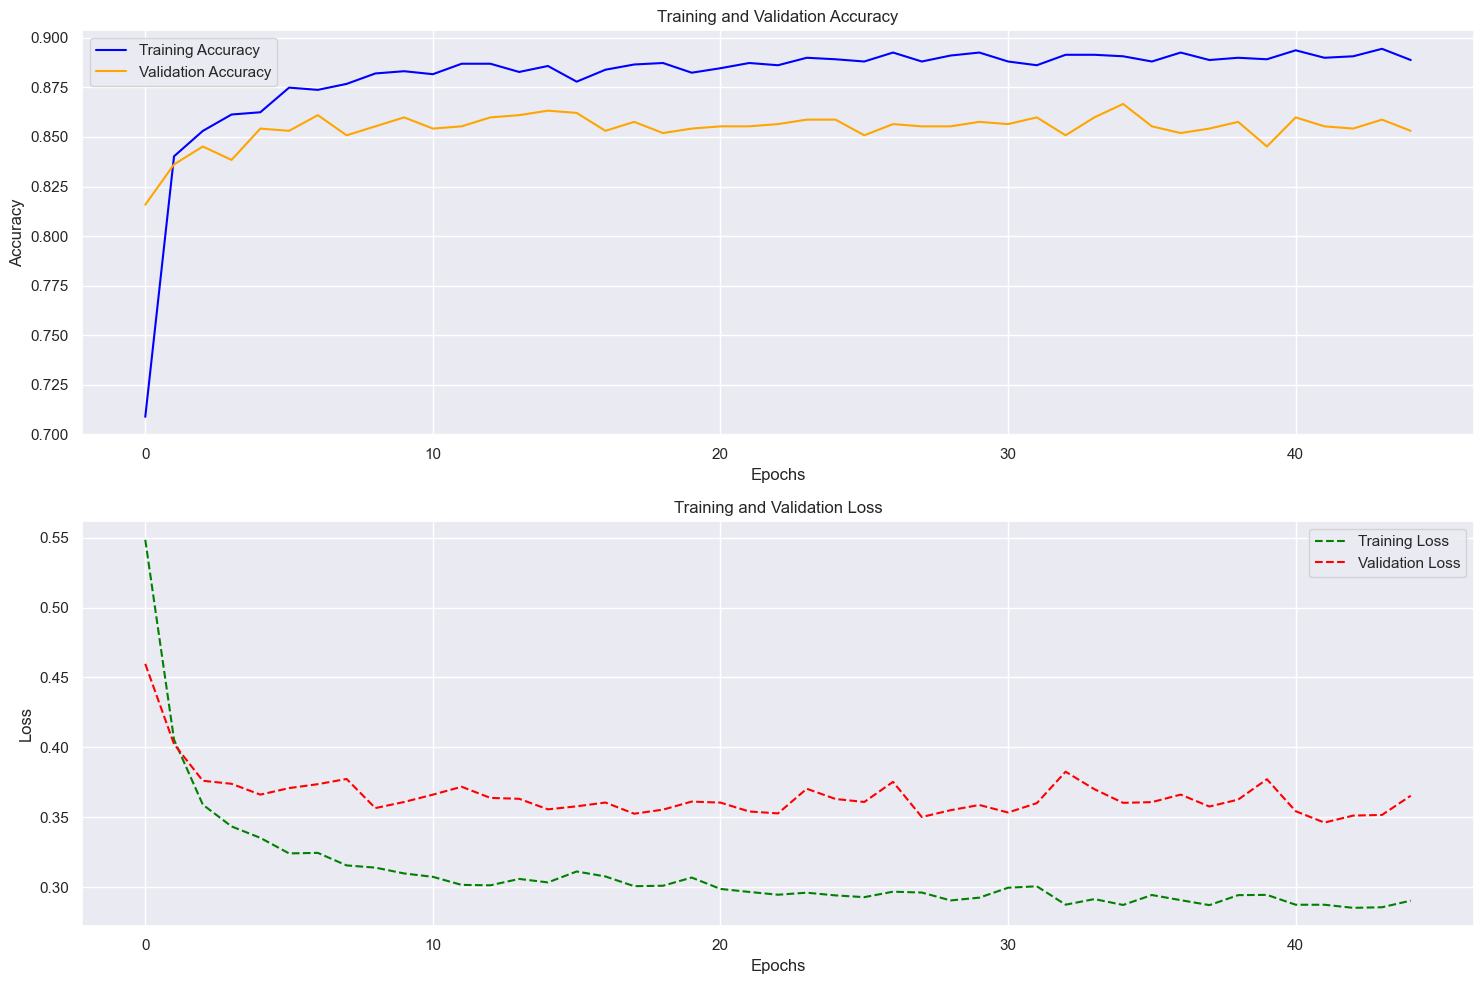

In [57]:
plot_loss_accuracy(history_7)


 Model Evaluation Result For the Test Phase 

28/28 [==============================] - 0s 4ms/step
Test Time(s): 0.31649860000470653
Accuracy:  87.0%

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       594
           1       0.87      0.70      0.78       291

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.86       885
 



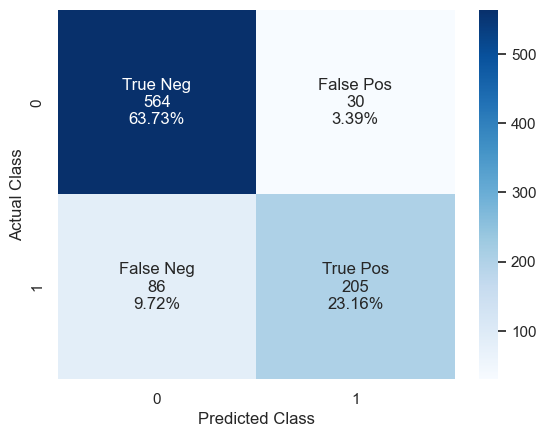

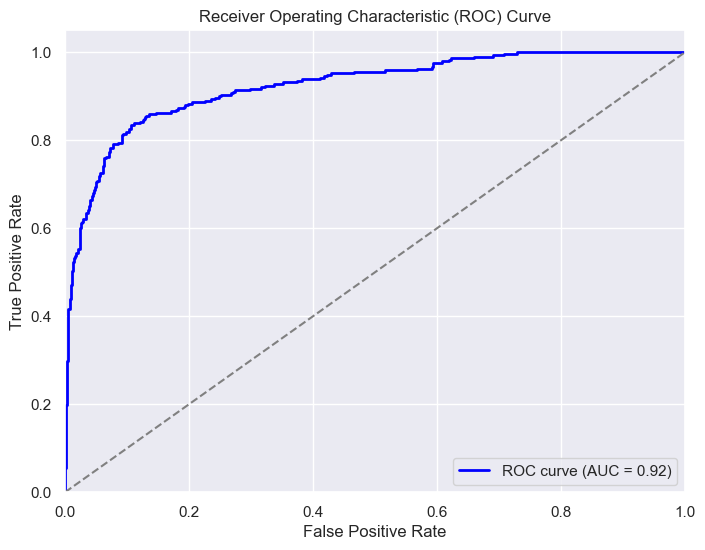

In [58]:
ANN_model_evaluation(model5, x_test, y_test, phase = 'Test')

In [64]:
save_keras_model(model, 'model6.keras')

Keras model saved successfully to model6.keras


In [60]:
plot_model(model, to_file="model6.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
